### This notebook
builds a graph-based embedding for a small number of random handwritten digits with multidimensional scaling.

Optional: run this before import to recompile c++ ops
```
!rm -r ../lib/cpp/temp/
!rm -r ../lib/cpp/build/
!rm -r ../lib/cpp/_bindings.so
!rm -r ../lib/cpp/bindings.py
!rm -r ../lib/cpp/lib_wrap.c
```


##### Get the dataset:

In [ ]:
!rm -r ../lib/cpp/temp/
!rm -r ../lib/cpp/build/
!rm -r ../lib/cpp/_bindings.so
!rm -r ../lib/cpp/bindings.py
!rm -r ../lib/cpp/lib_wrap.c

In [1]:
%load_ext autoreload
%autoreload 2
import gc
import pickle
import sys
sys.path.insert(0, "..")
import time

import h5py
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import torchvision
from tqdm.notebook import tqdm

torch.manual_seed(42)

import lib # builds c++ binaries with swig
from lib.utils.distance_helper import compute_original_pairwise_distance, compute_pca_pairwise_distance, mds_pairwise_distance
from lib import data_loader as data_loader

#### Choose one of the 3 cells below to run

In [ ]:
dataset = 'mnist'
batch_size = 64

In [2]:
dataset = 'iris'
batch_size = 256

In [ ]:
dataset = 'wine'
batch_size = 256

#### Load dataset

In [3]:
if dataset == 'mnist':
    X, y = data_loader.get_mnist()
elif dataset == 'iris':
    X, y = data_loader.get_iris()
elif dataset == 'wine':
    X, y = data_loader.get_wine()
else:
    raise Exception(f"Unspecified dataset: {dataset}")

#### Compute PCA and MDS compression MSE

In [4]:
distances = compute_original_pairwise_distance(X, simple=True, num_samples=len(X))
n_comp = 4 if dataset != 'iris' else 3 # IRIS dataset only has 4 attributes
dist_pca = compute_pca_pairwise_distance(X, simple=True, num_samples=len(X), n_comp=n_comp)
dist_mds = mds_pairwise_distance(X, n_comp=n_comp)

##### Build initial graph

We initialize prodige with a full graph initialized with distances between nodes

In [6]:
emb = lib.make_graph_from_vectors(
        X, knn_edges=64, random_edges=32, squared=False,
        max_length=10, n_jobs=-1, soft=True, k_nearest=0, directed=False, verbose=True
)

loss_history, reg_history = [], []
opt = None
total_edges = emb.num_edges
num_edges_req = len(X) * 2 * 1.1  # x 1.1 as buffer
stage, last_updated = 0, 0

def update_learning_rate(decrease_lr:bool = True):
    t = len(loss_history)
    global opt, stage, emb, batch_size
    
    if decrease_lr is False:
        emb = emb.pruned(threshold=0.5)
        opt = torch.optim.SparseAdam(emb.parameters(), lr=0.01)
    else:
        if stage == 0:
            opt = torch.optim.SparseAdam(emb.parameters(), lr=0.1)
            stage += 1

        elif stage == 1: # and t >= 300:
            emb = emb.pruned(threshold=0.5)
            opt = torch.optim.SparseAdam(emb.parameters(), lr=0.05)
            stage += 1

        elif stage == 2: # and t >= 1000:
            emb = emb.pruned(threshold=0.5)
            opt = torch.optim.SparseAdam(emb.parameters(), lr=0.01)
            stage += 1

        elif stage == 3:
            emb = emb.pruned(threshold=0.5)
            opt = torch.optim.SparseAdam(emb.parameters(), lr=0.005)
            stage += 1

Searching for nearest neighbors
Adding knn edges
Adding random edges
Deduplicating edges
Total edges: 7670, mean edges per vertex: 51.13333333333333, mean distance: 0.1727593527919499


##### Training loop

Here we minimize the MDS loss function
$$L = 1/N \sum_{i, j} (d_{orig}(x_i, x_j) - d_G(v_i, v_j))^2$$

* $d_{orig}(x_i, x_j)$ is the original distance between two vectors in $X$
* $d_G(v_i, v_j)$ is the learned graph distance between corresponding vertices in graph $G$

Stage: 4 Last updated: 10267


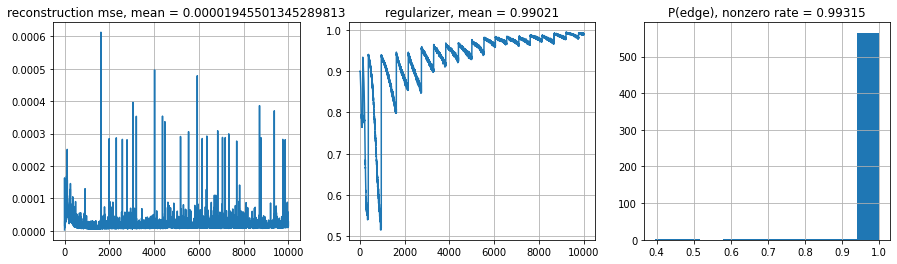

GraphEmbedding(150 vertices, 584 edges total, 580 edges kept, 0.0068493 sparsity rate, default distance = 0.0)



In [7]:
update_learning_rate()
for batch_i in tqdm(range(len(loss_history), 10000)):
    ii = torch.randint(0, len(X), [batch_size])
    jj = torch.randint(0, len(X), [batch_size])

    pred = emb(ii, jj)
    distances_ref = torch.as_tensor(distances[ii, jj], dtype=torch.float32)
    
    reconstruction_mse = F.mse_loss(pred['target_distances'], distances_ref)
    regularizer = emb.compute_l0_prior_penalty(batch_size=4096)
    lambd = min(1, len(loss_history) / 10000.) * (emb.num_edges / total_edges) * 10.0
    loss = reconstruction_mse - pred['logp_target_paths'].mean() + lambd * regularizer
    opt.zero_grad()
    loss.backward()
    opt.step()
    loss_history.append(reconstruction_mse.item())
    reg_history.append(regularizer.item())
    
    # early stopping       
    edges_kept = np.sum(lib.check_numpy(emb.edge_adjacency_logits >= 0).astype('int64'))
    if edges_kept <= num_edges_req:
        print('Early stopping at epoch:', batch_i)
        break

    # dynamic updating of LR/pruning  
    if len(reg_history) > 100 and batch_i > last_updated:
        limit = round(reg_history[-30], 3)
        if stage <= 3:
            if all(round(i, 3) >= limit for i in reg_history[-30:]):
                update_learning_rate()
                last_updated = batch_i + 50
        else:
            if all(round(i, 3) >= limit for i in reg_history[-30:]):
                update_learning_rate(decrease_lr=False)
                last_updated = batch_i + 500

    if len(loss_history) % 100 == 0:
        clear_output(True)
        plt.figure(figsize=[15, 4])
        plt.subplot(1, 3, 1);
        plt.title('reconstruction mse, mean = %.20f' % np.mean(loss_history[-100:])); plt.grid()
        plt.plot(loss_history)

        plt.subplot(1, 3, 2);
        plt.title('regularizer, mean = %0.5f' % np.mean(reg_history[-100:])); plt.grid()
        plt.plot(reg_history)

        plt.subplot(1, 3, 3);
        probs = torch.sigmoid(emb.edge_adjacency_logits).data.numpy().flatten()
        nnz_rate = np.mean(probs > 0.5)
        plt.title('P(edge), nonzero rate = %.5f' % nnz_rate); plt.grid();
        plt.hist(probs)
        plt.show()
        print(emb)

In [9]:
dist_prodige = emb.compute_pairwise_distances()
emb.report_model_size()

{'size_bytes': 5244.0,
 'num_parameters': 1311,
 'trainable_default': 1,
 'num_vertices': 152,
 'num_slices': 151,
 'num_edges': 579,
 'bits_per_int': 32,
 'bits_per_float': 32,
 'threshold': 0.5,
 'self': GraphEmbedding(150 vertices, 584 edges total, 580 edges kept, 0.0068493 sparsity rate, default distance = 0.0)}

In [11]:
print("PCA:\t %.5f" % np.mean(np.square(distances - dist_pca)))
print("MDS:\t %.5f" % np.mean(np.square(distances - dist_mds)))
print("PRODIGE: %.5f" % np.mean(np.square(distances - dist_prodige)))

PCA:	 0.00000
MDS:	 0.00004
PRODIGE: 0.00001


#### Visualize PRODIGE graph as TNSE graph

In [ ]:
from bokeh import io
from bokeh.plotting import figure, output_file, save
output_file('mnist_graph.html')
emb.default_distance.data[...] = 100
p = lib.visualize_embeddings(emb, vertex_labels=y, edge_probability_threshold=0.5, deterministic=True,
                         vertex_alpha=0.8, cmap=lambda x: plt.get_cmap('rainbow')(x))
save(p, 'mnist_graph.html')

In [ ]:
from IPython.display import HTML
HTML(filename="mnist_graph.html")
# re-run several times to get different tsne optima

```

```

```

```

```

```

```

```

```

```
